### Project Group 1 in Practical Planning Robust Behavior for autonomous driving
# Reinforcement Learning using Graph Neural Networks

### Tom Dörr, Marco Oliva, Quoc Trung Nguyen, Silvan Wimmer

__Objective__: Implement an reinforcement learning (RL) approach to train a graph neural network (GNN) in the setting of autonomous driving.
## Chapter 0: Setting up
### 0.0: Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#import matplotlib as mpl
import os
import networkx as nx
import time
#import json
#import pickle
#import logging
from collections import OrderedDict
from matplotlib.patches import Ellipse
from IPython.display import clear_output
import random

In [2]:
# BARK imports
from bark.runtime.commons.parameters import ParameterServer
from bark.runtime.viewer.matplotlib_viewer import MPViewer
from bark.runtime.viewer.video_renderer import VideoRenderer

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
# BARK-ML imports
from bark_ml.environments.blueprints import ContinuousHighwayBlueprint, \
  ContinuousMergingBlueprint, ContinuousIntersectionBlueprint
from bark_ml.environments.single_agent_runtime import SingleAgentRuntime
from bark_ml.library_wrappers.lib_tf_agents.agents import BehaviorSACAgent, BehaviorPPOAgent, BehaviorGraphSACAgent
#from bark_ml.library_wrappers.lib_tf_agents.runners import SACRunner, PPORunner
from bark_ml.observers.graph_observer import GraphObserver
#from bark_ml.library_wrappers.lib_tf2_gnn import GNNActorNetwork, GNNCriticNetwork

In [4]:
from supervised_learning.data_generation import DataGenerator
from supervised_learning.data_handler import Dataset
from supervised_learning.learner import Learner

### 0.1: Local variables for this notebook

In [5]:
normalization_ref_highway = OrderedDict([('x', [5112.68310546875, 5119.88330078125]),
                                         ('y', [5054.984375, 5304.984375]),
                                         ('theta', [0, 6.283185307179586]),
                                         ('vel', [0, 100]),
                                         ('distance', [0, 250.10366413257154]),
                                         ('dx', [-7.2001953125, 7.2001953125]),
                                         ('dy', [-250.0, 250.0])])

params_path = os.path.join("data", "tfa_params.json")
params = ParameterServer(filename=params_path)
params["World"]["remove_agents_out_of_map"] = False
data_path = os.path.join("data")

visible_distance = params["ML"]["GraphObserver"]["VisibilityRadius", "", 50]

In [ ]:
bark_path = os.path.join("/home", "silvan", "working_bark")
bark_path

### 0.2: Local functions (will be transfered to helper_functions.py, but easier prototyping here)

In [6]:
from docs.report.helper_functions import visualize_graph

## Chapter 1: Reinforcement learning setting
- what learning setting we have (observation, action, reward)
- SAC approach with actor net outputting distributions of actions and critic net
- ...

In [17]:
graph_generator = DataGenerator(num_scenarios=3, dump_dir=data_path, params=params)
print('Observation space has shape {} \nwith minimum value \n{} \nand maximum value \n{}'.format(graph_generator.env.observation_space.shape, graph_generator.env.observation_space.low, graph_generator.env.observation_space.high))
print('Action space has shape {}\n with minimum value \n{}\nand maximum value \n{}'.format(graph_generator.env.action_space.shape, graph_generator.env.action_space.low, graph_generator.env.action_space.high))


Observation space has shape (279,) 
with minimum value 
[ 0.  0.  0. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.

In the reinforcement learning problem, the observation of environment has size of **3**+**agent_limit** x **feature_len** + size(**adjacency_matrix**), in which: 
- **agent_limit** is the maximum number of agents that can be observed
- **feature_len** is number feature per agent 
- **adjacency_matrix** represent relation between one agent with other agents, which has size **agent_limit** x **agent_limit** 
- the first three components are maximum number of agents, actual number of agents and number of feature per agent

In this case, **agent_limmit** = 12 and **feature_len** = 11

The action has size of 2, which represent the steering and acceleration of agent, respectively

The reward is assigned as follows: 
 - If the agent reaches goal, it receives reward of 1
 - If the agent crashes, it receives reward of -1
 - For each time step that the agent does not crash, it receives a reward of 0.01
 
Our project implements the Soft Actor Critic algorithm for solving the reinforement learning problem. It consists of two different network: 
  - The **Critic network** receives observation and action as inputs and tries to approximate the action-value function $Q_{\phi_i}(s,a)$ to the true action-value function $Q^{\pi}(s,a)$. More specifically, it tries to minimize the error between approximated and target value function
  \begin{equation}
  $L(\phi_i, {\mathcal D}) = \underset{(s,a,r,s',d) \sim {\mathcal D}}{{\mathrm E}}\left[
    \Bigg( Q_{\phi_i}(s,a) - y(r,s',d) \Bigg)^2
    \right]$
  \end{equation}

    
    
    where the target is given by 
   \begin{equation}
    $y(r, s', d) = r + \gamma (1 - d) \left( \min_{j=1,2} Q_{\phi_{\text{targ},j}}(s', \tilde{a}') - \alpha \log \pi_{\theta}(\tilde{a}'|s') \right), \;\;\;\;\; \tilde{a}' \sim \pi_{\theta}(\cdot|s')$
   \end{equation}

    
  - The **Actor network** receives observation as inputs and tries to predict the optimal action, which maximize the expected future return plus expected future entropy
  \begin{split}
V^{\pi}(s)&= E_{a \sim \pi}[{Q^{\pi}(s,a)} + \alpha H\left(\pi(\cdot|s)\right)] \\
 &= E_{a \sim \pi}[{Q^{\pi}(s,a) - \alpha \log \pi(a|s)}]
\end{split}

 

## Chapter 2: Observervation of graph data - GraphObserver
- generate some dummy data to show graph observation
- explain a single observation

INFO:root:Running data_generation on scenario 1/3
INFO:root:Running data_generation on scenario 2/3
INFO:root:Running data_generation on scenario 3/3
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymBol.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymReg.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-BoldItalic.ttf) italic normal bold normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 0.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMo

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Mono' (LiberationMono-Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Ubuntu Mono' (UbuntuMono-B.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kinnari' (Kinnari-Bold.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Abyssinica SIL' (AbyssinicaSIL-R.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'rsfs10' (rsfs10.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Sawasdee' (Sawasdee.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Rachana' (Rachana-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Sans' (LiberationSans-Bold.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_m

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Bitstream Vera Serif' (VeraSeBd.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Samanata' (samanata.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'RaghuMalayalam' (RaghuMalayalamSans-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerifCondensed.ttf) normal normal 400 condensed>) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Serif' (LiberationSerif-Bold.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Bitstream Vera Sans' (Vera.ttf) normal normal 400 normal>) = 0.9590909090909092
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Khmer OS System' (KhmerOSsys.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Sawasdee' (Sawasdee-Oblique.ttf) oblique nor

DEBUG:matplotlib.font_manager:findfont: score(<Font 'eufm10' (eufm10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Loma' (Loma-Bold.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans CJK JP' (NotoSansCJK-Regular.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'KacstPoster' (KacstPoster.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'KacstQurn' (KacstQurn.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSansCondensed-BoldOblique.ttf) oblique normal bold condensed>) = 1.535
DEBUG:matplotlib.font_manager:findfont: score(<Font 'KacstFarsi' (KacstFarsi.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Manjari' (Manjari-Bold.otf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:find

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Padauk' (Padauk-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Umpush' (Umpush-Light.ttf) normal normal light normal>) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Mitra Mono' (mitra.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/home/trung/bark-ml/bark_ml/python_wrapper/venv/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.


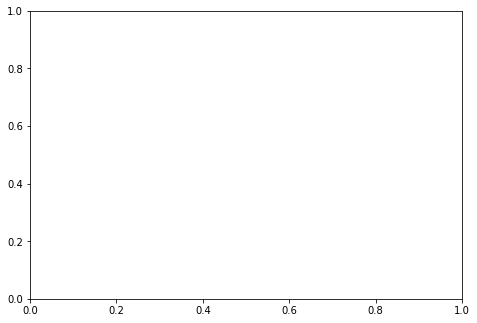

In [7]:
scenario_data = graph_generator.run_scenarios()
# Window popping up due to MPViewer of BARK lib - not our fault!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymBol.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymReg.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-BoldItalic.ttf) italic normal bold normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 0.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymReg.ttf) no

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Ubuntu Mono' (UbuntuMono-B.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kinnari' (Kinnari-Bold.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Abyssinica SIL' (AbyssinicaSIL-R.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'rsfs10' (rsfs10.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Sawasdee' (Sawasdee.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Rachana' (Rachana-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Sans' (LiberationSans-Bold.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-ExtraLight.ttf) normal normal light normal>) = 0.24
DEBUG:matplotlib.font_mana

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Samanata' (samanata.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'RaghuMalayalam' (RaghuMalayalamSans-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerifCondensed.ttf) normal normal 400 condensed>) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Serif' (LiberationSerif-Bold.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Bitstream Vera Sans' (Vera.ttf) normal normal 400 normal>) = 0.9590909090909092
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Khmer OS System' (KhmerOSsys.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Sawasdee' (Sawasdee-Oblique.ttf) oblique normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Lato' (Lato-LightItalic.ttf) italic normal light 

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Loma' (Loma-Bold.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans CJK JP' (NotoSansCJK-Regular.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'KacstPoster' (KacstPoster.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'KacstQurn' (KacstQurn.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSansCondensed-BoldOblique.ttf) oblique normal bold condensed>) = 1.535
DEBUG:matplotlib.font_manager:findfont: score(<Font 'KacstFarsi' (KacstFarsi.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Manjari' (Manjari-Bold.otf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Lohit Tamil Classical' (Lohit-Tamil-Classical.ttf) normal normal 400 normal>) = 10.05
DEBU

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Umpush' (Umpush-Light.ttf) normal normal light normal>) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Mitra Mono' (mitra.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('/home/trung/bark-ml/bark_ml/python_wrapper/venv/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.


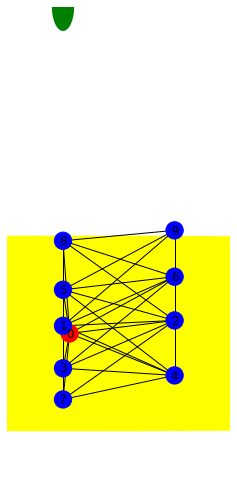

In [8]:
# Select random data_point from data_set
data_point = random.choice(random.choice(scenario_data))
observation = data_point["graph"]
graph = GraphObserver.graph_from_observation(observation)

# Visualize datapoint (graph data)
fig = plt.figure(figsize=(4,9))
ax  = fig.add_subplot(111)
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
visualize_graph(data_point, ax, visible_distance, normalization_ref_highway)

The image from above shows the perceived environment from the agent's perspective in graph structure:
- the red node is the $\color{red}{\text{controlled/ego agent}}$
- the blue agents are $\color{blue}{\text{other agents which are not controlled}}$
- the yellow zone indicates the <mark>area that agents are visible to the ego agent<mark>. Visibility is further indicated by the missing connections to agents outside the zone
- the green point shows the $\color{green}{\text{goal of the ego agent}}$

About every other agent that the ego agent is perceiving (and about itself) the following information are represented in the individual node features:
- Position -> $x$ and $y$-Coordinates
- Orientation -> $\theta$
- Velocity -> $v$
- Information related to the goal:
    - Position of goal -> $x_{goal}$ and $y_{goal}$-Coordinates
    - Distance to goal -> $dx$ and $dy$ and $d=\sqrt {dx²+dy²}$
    - Necessary orientation at goal position -> $\theta_{goal}$
    - Necessary velocity at goal position -> $v_{goal}$
    
The following cell shows the keys under which the node_features are accessible:

In [9]:
node_features = graph.nodes[1].keys()
node_features

dict_keys(['x', 'y', 'theta', 'vel', 'goal_x', 'goal_y', 'goal_dx', 'goal_dy', 'goal_theta', 'goal_d', 'goal_vel'])

## Chapter 3: Wrapping stuff
- why we have to use wrappers
- how we use them (from what to what)

In [ ]:
#to do

## Chaper 4: Graph Neural Network
- what structure we use
- what layer types, ...

In [ ]:
#to do

## Chapter 5: Evaluation of capabilites of actor net
- introduce supervised setting
- benchmark GNN-SAC vs SAC, randomActor and ConstantActor

In [ ]:
# to do

## Chapter 6: Reinforcement learning of GNN-SAC
- show commands for training
- benchmark training with normal SAC and possibly with different parameters

## Chapter 7: Summary

## Apendix: Commands 

In [ ]:
os.getcwd()

# Run bazel commands from here (no visualizations)

In [ ]:
!pwd

!cd /home/silvan/working_bark && bazel run //examples:tfa

In [ ]:
!cd /home/silvan/working_bark && bazel run //examples:tfa